#### ДЗ_33  - определение возраста при помощи ансамбля моделей
#### Татур А.А.
##### 02.04.2023

#### Взять за основу любое предыдущее задание и реализовать стекинг несколькоих моделей

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
from tqdm import tqdm

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, CategoryEncoding, AveragePooling2D,\
                                    Dropout, BatchNormalization, AveragePooling2D, GlobalMaxPool2D
from tensorflow.keras.regularizers import l2
import tensorflow_hub as hub
from tensorflow.keras.models import Sequential, load_model, Model

from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.metrics import RootMeanSquaredError
import tensorflow as tf

from tensorflow.keras.layers import Concatenate, Input

pd.set_option('display.max_rows', 30)

from tensorflow.keras.applications import VGG16, MobileNet
from tensorflow.keras.utils import plot_model 

import gc

In [2]:
#### Функция для построения графика обучения на тренировочном и обучающем наборе:
def test_val_graph (history,train,val):
    plt.plot(history.history[train], label='Точность на обучающем наборе')
    plt.plot(history.history[val], label='Точность на проверочном наборе')
    plt.xlabel('Цикл обучения')
    plt.ylabel('Точность')
    plt.legend()
    plt.show()
    pass;

#### 01. Загружаем файлы. Формируем датайфрейм ссылка/возраст для фалов с лицами. Сохраняем в .csv файл

In [3]:
df = pd.DataFrame() ### Создаем пустой Dataframe

for file_name in tqdm(os.listdir('D:\\UTKFace\\')):
    #формируем ссылку на изображение
    link = 'D:\\UTKFace\\' + file_name
    
    name = file_name[:-4] #убираем расширение файла из имени
    age = name.split('_')[0] # делаем сплит по нижнему подчеркиванию и выбираем дату
            
    #формируем временный датафрейм
    data = pd.DataFrame({'link': [str(link)],
                         'age': [int(age)]})
            #Делаем конкатенацию с основным датафреймом.
    df = pd.concat([df,data], axis=0)

df.to_csv('data_UTK.csv',
          index=False) #Сохраним в файл полученный Dataframe на случай перезагрузки, чтобы не чистить второй раз )))

#### 01.2. Загрузим полученный датасет

In [4]:
df = pd.read_csv ('data_UTK.csv')

In [5]:
df

,link,age
0,D:\UTKFace\100_0_0_20170112213500903.jpg.chip.jpg,100
1,D:\UTKFace\100_0_0_20170112215240346.jpg.chip.jpg,100
2,D:\UTKFace\100_1_0_20170110183726390.jpg.chip.jpg,100
3,D:\UTKFace\100_1_0_20170112213001988.jpg.chip.jpg,100
4,D:\UTKFace\100_1_0_20170112213303693.jpg.chip.jpg,100
...,...,...
23703,D:\UTKFace\9_1_3_20161220222856346.jpg.chip.jpg,9
23704,D:\UTKFace\9_1_3_20170104222949455.jpg.chip.jpg,9
23705,D:\UTKFace\9_1_4_20170103200637399.jpg.chip.jpg,9
23706,D:\UTKFace\9_1_4_20170103200814791.jpg.chip.jpg,9


#### Выведем рандомные 25 изображений из полученного списка

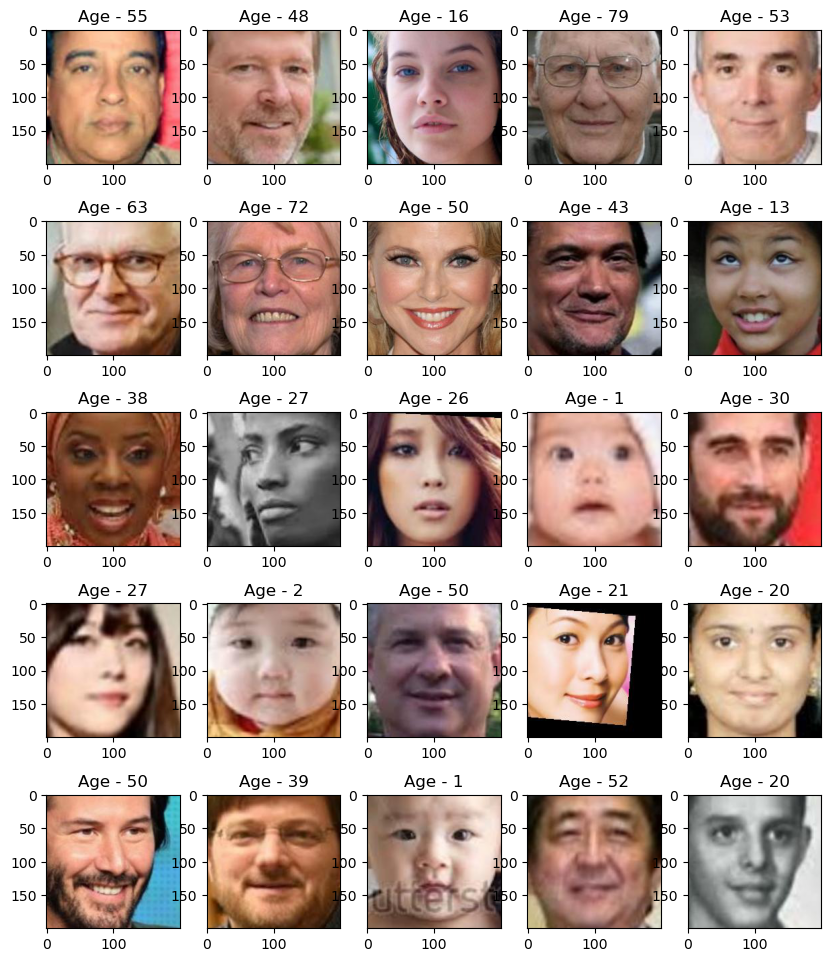

In [6]:
idx = np.random.randint (0,len(df),25)
plt.figure(figsize=(10,12))
for idx in enumerate(idx):
    plt.subplot (5,5,idx[0]+1)
    link = df.iloc[idx[1]]
    image = plt.imread(link[0])
    title = 'Age - ' + str(link[1])
    plt.title (title)
    plt.imshow(image, cmap='gray');

#### 02. Загружаем сет. Формируем тренировочный и тестовый набор

In [7]:
train, test = train_test_split(df, test_size=0.2, random_state=34)

#### 03. Создаем генератор

In [8]:
train_datagen=ImageDataGenerator(rescale=1./255.,validation_split=0.3)
test_datagen=ImageDataGenerator(rescale=1./255.)

In [24]:
TARGET_SIZE = (128,128)
BATCH_SIZE = 8

train_generator=train_datagen.flow_from_dataframe(
dataframe=train,
directory="./",
x_col="link",
y_col="age",
subset="training",
batch_size=BATCH_SIZE,
seed=42,
shuffle=True,
class_mode="raw",
color_mode='rgb',
target_size=TARGET_SIZE)

valid_generator=train_datagen.flow_from_dataframe(
dataframe=train,
directory="./",
x_col="link",
y_col="age",
subset="validation",
batch_size=BATCH_SIZE,
seed=42,
shuffle=True,
class_mode="raw",
color_mode='rgb',
target_size=TARGET_SIZE)

test_generator=test_datagen.flow_from_dataframe(
dataframe=test,
directory="./",
x_col="link",
y_col="age",
batch_size=BATCH_SIZE,
seed=42,
shuffle=False,
class_mode="raw",
color_mode='rgb',
target_size=TARGET_SIZE)

Found 13277 validated image filenames.
Found 5689 validated image filenames.
Found 4742 validated image filenames.


#### 03. Создаем архитектуру собственной модели

In [10]:
model_conv = Sequential()

model_conv.add (Conv2D(64, (3,3), padding='same', activation='relu', input_shape=(128,128,3)))
model_conv.add (MaxPooling2D(pool_size=(2,2), strides=2))

model_conv.add (Conv2D(128, (3,3), padding='same', activation='relu'))
model_conv.add (MaxPooling2D(pool_size=(2,2), strides=2))

model_conv.add (Conv2D(256, (3,3), padding='same', activation='relu'))
model_conv.add (MaxPooling2D(pool_size=(2,2), strides=2))

model_conv.add (Conv2D(512, (3,3), padding='same', activation='relu'))
model_conv.add (MaxPooling2D(pool_size=(2,2), strides=2))

model_conv.add (Conv2D(512, (3,3), padding='same', activation='relu'))
model_conv.add (MaxPooling2D(pool_size=(2,2), strides=2))

model_conv.add(GlobalMaxPool2D())

model_conv.add(Dense(1000, activation='relu'))
model_conv.add (Dropout(0.5))

model_conv.add(Dense(1, activation='linear'))

In [112]:
model_conv.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_82 (Conv2D)          (None, 128, 128, 64)      1792      
                                                                 
 max_pooling2d_82 (MaxPoolin  (None, 64, 64, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_83 (Conv2D)          (None, 64, 64, 128)       73856     
                                                                 
 max_pooling2d_83 (MaxPoolin  (None, 32, 32, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_84 (Conv2D)          (None, 32, 32, 256)       295168    
                                                                 
 max_pooling2d_84 (MaxPoolin  (None, 16, 16, 256)    

#### 04. Обучаем собственную модель

Epoch 1/20
415/415 [==============================] - 37s 87ms/step - loss: 440.6444 - mae: 16.1177 - val_loss: 378.9202 - val_mae: 14.3337 - lr: 5.0000e-04
Epoch 2/20
415/415 [==============================] - 35s 85ms/step - loss: 314.3769 - mae: 13.5891 - val_loss: 286.3627 - val_mae: 13.8390 - lr: 5.0000e-04
Epoch 3/20
415/415 [==============================] - 35s 84ms/step - loss: 215.2957 - mae: 11.0505 - val_loss: 164.2391 - val_mae: 9.6143 - lr: 5.0000e-04
Epoch 4/20
415/415 [==============================] - 35s 85ms/step - loss: 165.2388 - mae: 9.5353 - val_loss: 134.0691 - val_mae: 8.4893 - lr: 5.0000e-04
Epoch 5/20
415/415 [==============================] - 35s 85ms/step - loss: 134.4757 - mae: 8.6021 - val_loss: 120.0686 - val_mae: 8.0003 - lr: 5.0000e-04
Epoch 6/20
415/415 [==============================] - 36s 85ms/step - loss: 115.2396 - mae: 7.9690 - val_loss: 106.1054 - val_mae: 7.4967 - lr: 5.0000e-04
Epoch 7/20
415/415 [==============================] - 35s 85ms/st

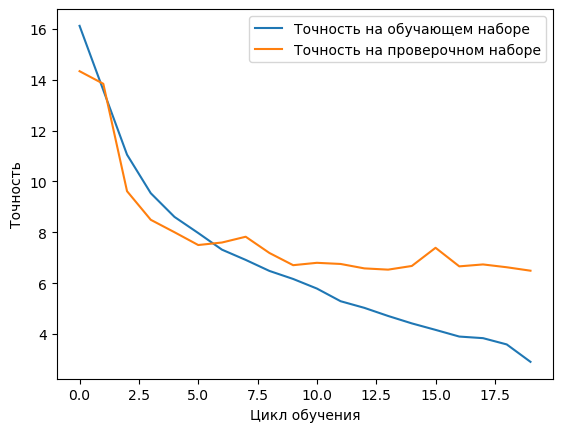

In [113]:
model_conv.compile(optimizer=Adam(learning_rate=0.0005), loss='mse', metrics=['mae'])

checkpoint_cb_conv = ModelCheckpoint("own_model.h5", 
                                     monitor = 'val_mae',
                                     save_best_only=True)

lr_scheduler = ReduceLROnPlateau(factor=0.2, 
                                 patience=5,  
                                 monitor = 'val_mae')

history_own = model_conv.fit(train_generator,
                           validation_data=valid_generator,
                           callbacks=[checkpoint_cb_conv,lr_scheduler],
                           epochs=20)

test_val_graph (history_own,'mae','val_mae')

In [123]:
del model_conv
gc.collect()

2478

In [134]:
model_conv = load_model("own_model.h5")

In [121]:
model_conv.evaluate (test_generator)

149/149 [==============================] - 29s 195ms/step - loss: 81.2517 - mae: 6.4534


[81.2516860961914, 6.4533796310424805]

#### 05. Берем предобученную модель VGG16 (отключаем все слои кроме 3-х последних и добавляем собственные)

In [11]:
vgg16 = VGG16(input_shape=(128,128,3), weights='imagenet', include_top=False) 

for i in vgg16.layers[:-3]:
    i.trainable = False 

# build model 
input = vgg16.layers[-1].output # input is the last output from vgg16 

x = Flatten()(input) 
x = Dense(1000, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(1, activation='linear')(x) 

# create the model 
vgg16_model = Model(vgg16.input, output, name='VGG16_Model')

Epoch 1/20
415/415 [==============================] - 36s 84ms/step - loss: 177.6941 - mae: 9.6042 - val_loss: 102.0750 - val_mae: 7.4274 - lr: 5.0000e-04
Epoch 2/20
415/415 [==============================] - 35s 84ms/step - loss: 94.3528 - mae: 7.1030 - val_loss: 91.2130 - val_mae: 6.8057 - lr: 5.0000e-04
Epoch 3/20
415/415 [==============================] - 34s 83ms/step - loss: 79.3510 - mae: 6.5271 - val_loss: 95.1250 - val_mae: 7.2797 - lr: 5.0000e-04
Epoch 4/20
415/415 [==============================] - 35s 84ms/step - loss: 66.0973 - mae: 5.9917 - val_loss: 86.9328 - val_mae: 6.6125 - lr: 5.0000e-04
Epoch 5/20
415/415 [==============================] - 34s 83ms/step - loss: 57.7680 - mae: 5.5956 - val_loss: 88.9767 - val_mae: 6.8232 - lr: 5.0000e-04
Epoch 6/20
415/415 [==============================] - 35s 84ms/step - loss: 47.7469 - mae: 5.1003 - val_loss: 77.6551 - val_mae: 6.3449 - lr: 5.0000e-04
Epoch 7/20
415/415 [==============================] - 35s 84ms/step - loss: 39.2

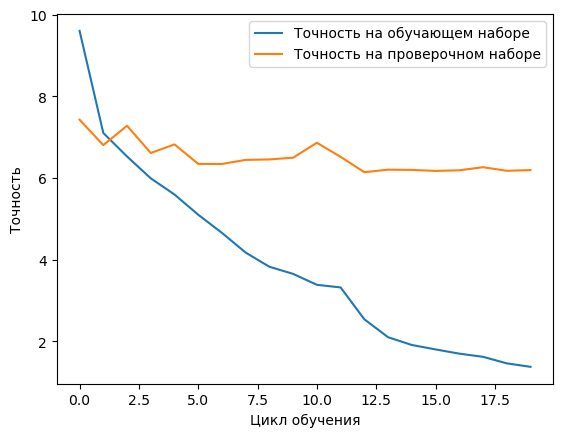

In [124]:
vgg16_model.compile(optimizer=Adam(learning_rate=0.0005), loss='mse', metrics=['mae'])

checkpoint_cb_conv = ModelCheckpoint("vgg16_model.h5", 
                                     monitor = 'val_mae',
                                     save_best_only=True)

lr_scheduler = ReduceLROnPlateau(factor=0.2, 
                                 patience=5,  
                                 monitor = 'val_mae')

history_vgg16 = vgg16_model.fit(train_generator,
                           validation_data=valid_generator,
                           callbacks=[checkpoint_cb_conv,lr_scheduler],
                           epochs=20)

test_val_graph (history_vgg16,'mae','val_mae')

In [125]:
del vgg16_model
gc.collect()

3832

In [126]:
model_vgg16 = load_model("vgg16_model.h5")

In [127]:
model_vgg16.evaluate (test_generator)

149/149 [==============================] - 9s 55ms/step - loss: 79.0328 - mae: 6.2294


[79.03279113769531, 6.229407787322998]

#### 06. Берем предобученную модель MobileNet (отключаем все слои кроме 5-х последних и добавляем собственные)

In [12]:
mobilenet = MobileNet(input_shape=(128, 128,3), weights='imagenet', include_top=False)

for layer in mobilenet.layers[:-5]:
    layer.trainable = False

input = mobilenet.layers[-1].output
x = Flatten()(input) 
x = Dense(1000, activation='relu')(x)
x = Dropout(0.3)(x)

output = Dense(1, activation='linear')(x) 

# Create the model
mobilenet_model = Model(mobilenet.input, output, name= "Mobilenet_Model")

Epoch 1/20
415/415 [==============================] - 29s 64ms/step - loss: 166.4595 - mae: 9.4993 - val_loss: 103.8251 - val_mae: 7.4174 - lr: 5.0000e-04
Epoch 2/20
415/415 [==============================] - 26s 62ms/step - loss: 91.0143 - mae: 7.1256 - val_loss: 89.2462 - val_mae: 6.8486 - lr: 5.0000e-04
Epoch 3/20
415/415 [==============================] - 25s 61ms/step - loss: 67.9106 - mae: 6.1995 - val_loss: 108.3333 - val_mae: 8.1220 - lr: 5.0000e-04
Epoch 4/20
415/415 [==============================] - 25s 61ms/step - loss: 50.9291 - mae: 5.3872 - val_loss: 85.9705 - val_mae: 6.8633 - lr: 5.0000e-04
Epoch 5/20
415/415 [==============================] - 25s 60ms/step - loss: 42.4673 - mae: 4.9007 - val_loss: 91.0149 - val_mae: 6.9260 - lr: 5.0000e-04
Epoch 6/20
415/415 [==============================] - 25s 59ms/step - loss: 36.7703 - mae: 4.5833 - val_loss: 88.6008 - val_mae: 7.0538 - lr: 5.0000e-04
Epoch 7/20
415/415 [==============================] - 24s 59ms/step - loss: 32.

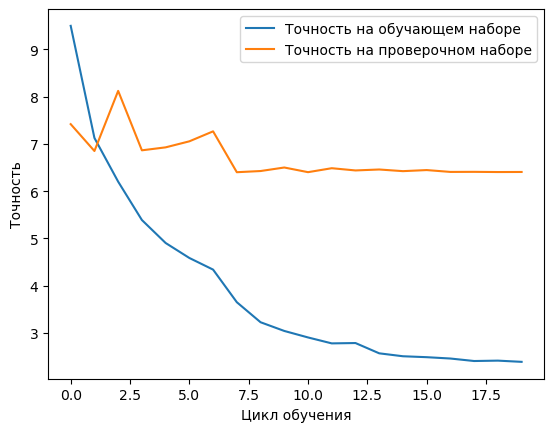

In [129]:
mobilenet_model.compile(optimizer=Adam(learning_rate=0.0005), loss='mse', metrics=['mae'])

checkpoint_cb_conv = ModelCheckpoint("mobilenet_model.h5", 
                                     monitor = 'val_mae',
                                     save_best_only=True)

lr_scheduler = ReduceLROnPlateau(factor=0.2, 
                                 patience=5,  
                                 monitor = 'val_mae')

history_mobilenet = mobilenet_model.fit(train_generator,
                           validation_data=valid_generator,
                           callbacks=[checkpoint_cb_conv,lr_scheduler],
                           epochs=20)

test_val_graph (history_mobilenet,'mae','val_mae')

In [130]:
del mobilenet_model
gc.collect()

4258

In [131]:
mobilenet_model = load_model("mobilenet_model.h5")

In [132]:
mobilenet_model.evaluate (test_generator)

149/149 [==============================] - 7s 44ms/step - loss: 82.6827 - mae: 6.4564


[82.68265533447266, 6.456449031829834]

#### 07. Конкатенируем модели в одну единую

In [30]:
models = [model_conv, vgg16_model, mobilenet_model]

input = Input(shape=(128, 128, 3), name='input')

outputs = [model(input) for model in models]

# contenate the ouputs
x = Concatenate()(outputs) 

# add further layers
x = Dense(100, activation='relu')(x)
x = Dropout(0.5)(x) 

output = Dense(1, activation='linear', name='output')(x) # output layer

# create concatenated model
conc_model = Model(input, output, name= 'Concatenated_Model')

In [31]:
conc_model.summary()

Model: "Concatenated_Model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential (Sequential)        (None, 1)            4424785     ['input[0][0]']                  
                                                                                                  
 VGG16_Model (Functional)       (None, 1)            22908689    ['input[0][0]']                  
                                                                                                  
 Mobilenet_Model (Functional)   (None, 1)            19614865    ['input[0][0]'] 

#### 08. Обучаем полученную модель

In [32]:
conc_model.compile(optimizer=Adam(learning_rate=0.00005), loss='mse', metrics=['mae'])

Epoch 1/20
1660/1660 [==============================] - 134s 79ms/step - loss: 554.8550 - mae: 17.3705 - val_loss: 122.2709 - val_mae: 8.0655 - lr: 5.0000e-05
Epoch 2/20
1660/1660 [==============================] - 111s 67ms/step - loss: 204.3980 - mae: 10.6931 - val_loss: 97.2186 - val_mae: 7.1792 - lr: 5.0000e-05
Epoch 3/20
1660/1660 [==============================] - 112s 67ms/step - loss: 164.9411 - mae: 9.5980 - val_loss: 93.0639 - val_mae: 6.9029 - lr: 5.0000e-05
Epoch 4/20
1660/1660 [==============================] - 111s 67ms/step - loss: 138.6599 - mae: 8.7523 - val_loss: 81.5172 - val_mae: 6.7418 - lr: 5.0000e-05
Epoch 5/20
1660/1660 [==============================] - 111s 67ms/step - loss: 120.1437 - mae: 8.0885 - val_loss: 78.9034 - val_mae: 6.4798 - lr: 5.0000e-05
Epoch 6/20
1660/1660 [==============================] - 110s 66ms/step - loss: 104.1140 - mae: 7.6048 - val_loss: 79.8563 - val_mae: 6.4919 - lr: 5.0000e-05
Epoch 7/20
1660/1660 [==============================] -

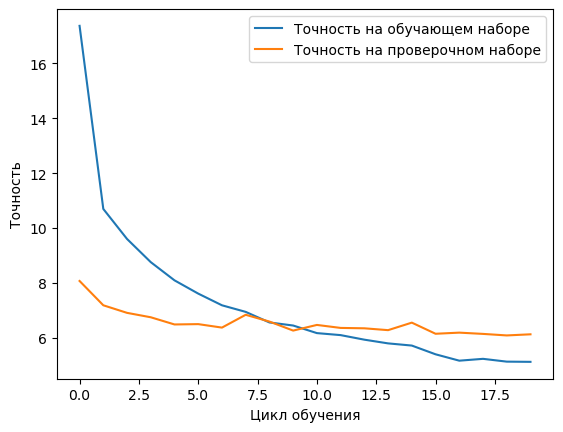

In [33]:
checkpoint_cb_conv = ModelCheckpoint("conc_model.h5", 
                                     monitor = 'val_mae',
                                     save_best_only=True)

lr_scheduler = ReduceLROnPlateau(factor=0.2, 
                                 patience=5,  
                                 monitor = 'val_mae')


history_conc  = conc_model.fit(train_generator,
                           validation_data=valid_generator,
                           callbacks=[checkpoint_cb_conv,lr_scheduler],
                           epochs=20)

test_val_graph (history_conc,'mae','val_mae')


In [34]:
del conc_model
gc.collect()

3960

In [35]:
conc_model = load_model("conc_model.h5")

In [36]:
conc_model.evaluate (test_generator)

593/593 [==============================] - 32s 53ms/step - loss: 73.5087 - mae: 6.0440


[73.50865173339844, 6.0440449714660645]

#### 04. Пробуем построить предсказание по фотографиям c помощью собственной сети.

1/1 [==============================] - 0s 37ms/step


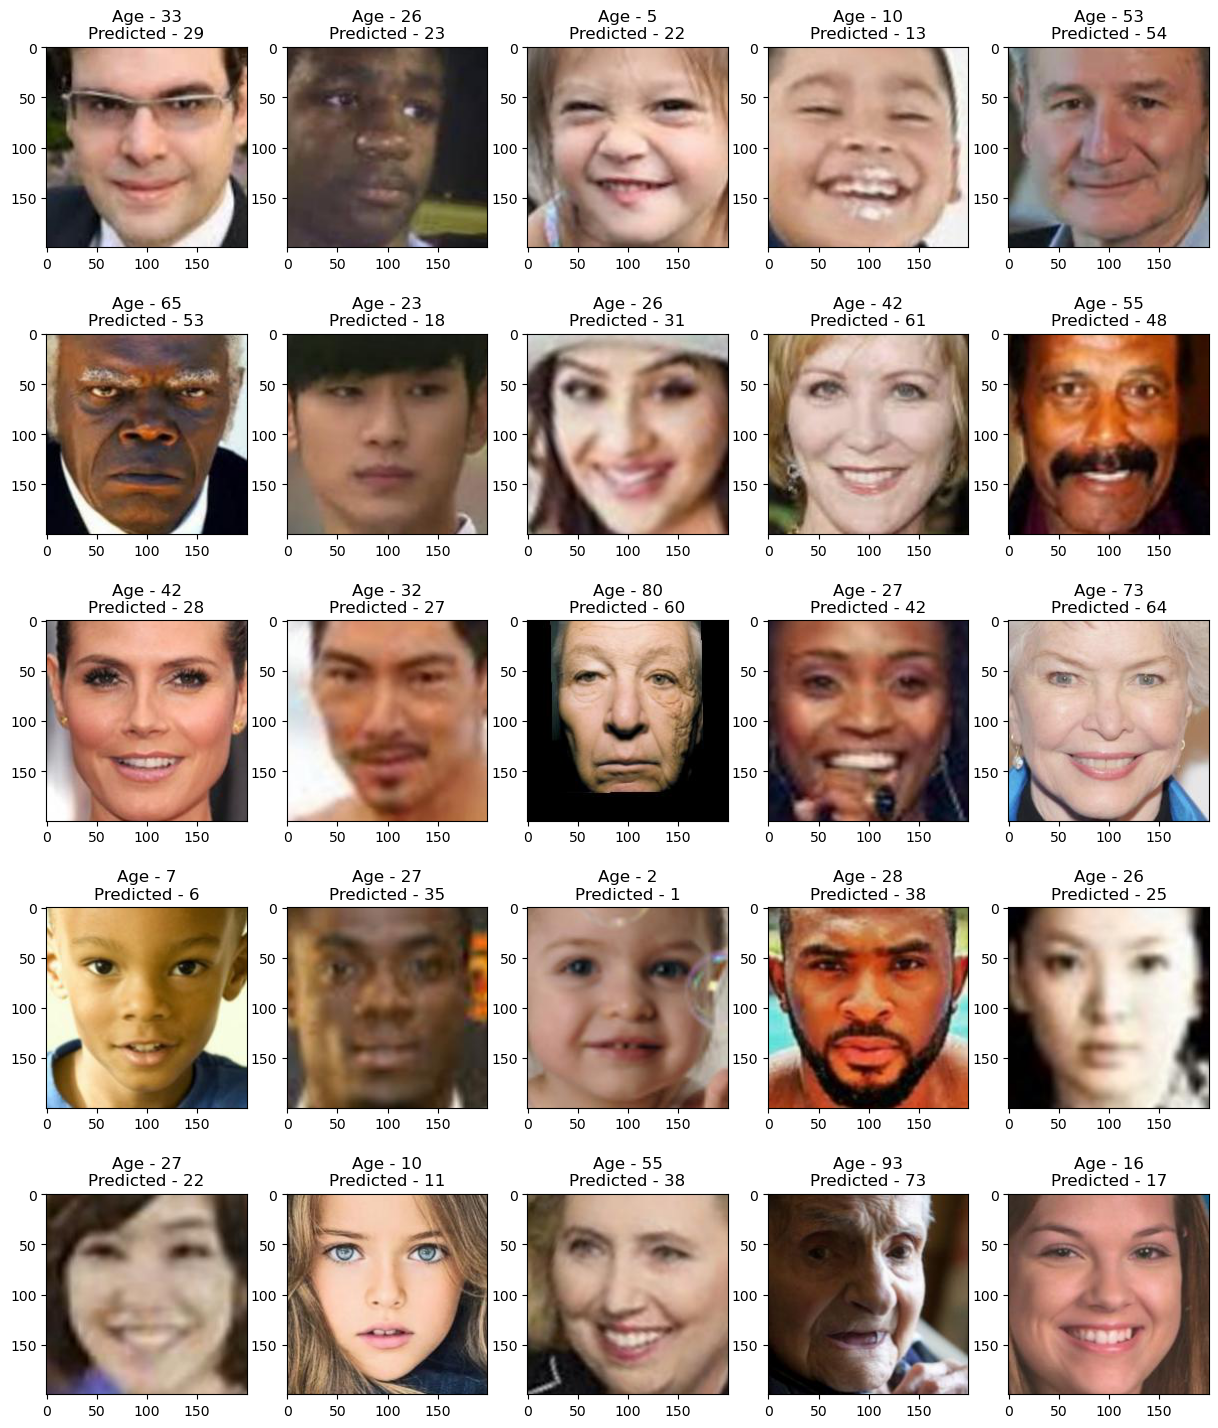

In [40]:
idx = np.random.randint (0,len(test),25)
plt.figure(figsize=(15,18))
for idx in enumerate(idx):
    plt.subplot (5,5,idx[0]+1)
    link = test.iloc[idx[1]]
    image = plt.imread(link[0])
    
    img_resized = cv2.resize (image, (128,128))/255 #,
    img_reshaped  = img_resized.reshape (1,128,128,3)
    predict = conc_model.predict(img_reshaped)[0][0];
    
    title = 'Age - ' + str(link[1]) + '\nPredicted - ' + str(int(predict))
    plt.title (title)
    plt.imshow(image, cmap='gray');